In [1]:
# !pip install mlflow
# !pip install wordcloud
# !pip install tensorflow
# !pip install keras

Client creating using default project: credit-suisse20-rem-2026


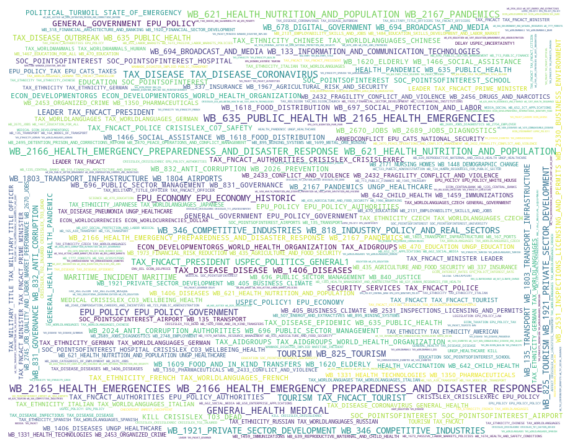

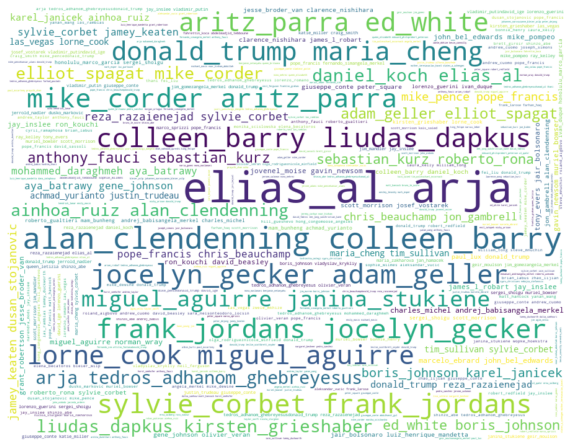

['soc_pointsofinterest_airport' 'wb_1804_airports'
 'tax_worldmammals_human' 'wb_1803_transport_infrastructure'
 'tax_fncact_prime_minister' 'tax_fncact_workers' 'ban' 'wb_135_transport'
 'tax_worldmammals' 'soc_quarantine']


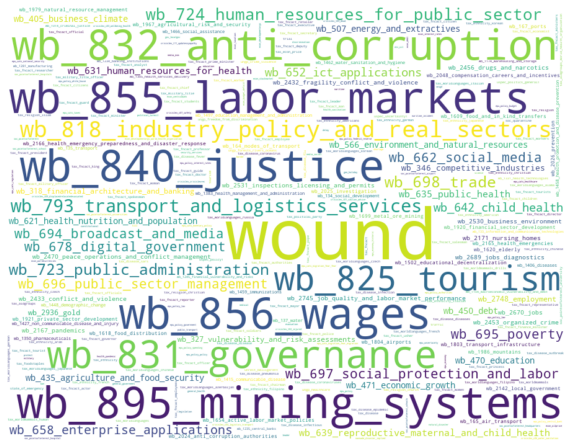

topic                                           keywords
0  Topic #1:   tax_disease, general_health, tax_fncact, touri...
1  Topic #2:   ungp_healthcare, wb_2166_health_emergency_prep...
2  Topic #3:   wb_507_energy_and_extractives, wb_895_mining_s...
3  Topic #4:   tax_disease, general_health, tourism, tax_fnca...
4  Topic #5:   wb_2432_fragility_conflict_and_violence, tax_f...
5  Topic #6:   tourism, tax_fncact, wb_1921_private_sector_de...
6  Topic #7:   wb_135_transport, tourism, tax_fncact, wb_1803...
7  Topic #8:   tax_religion, crisislex_t11_updatessympathy, c...
8  Topic #9:   uspec_policy1, epu_economy_historic, epu_econo...

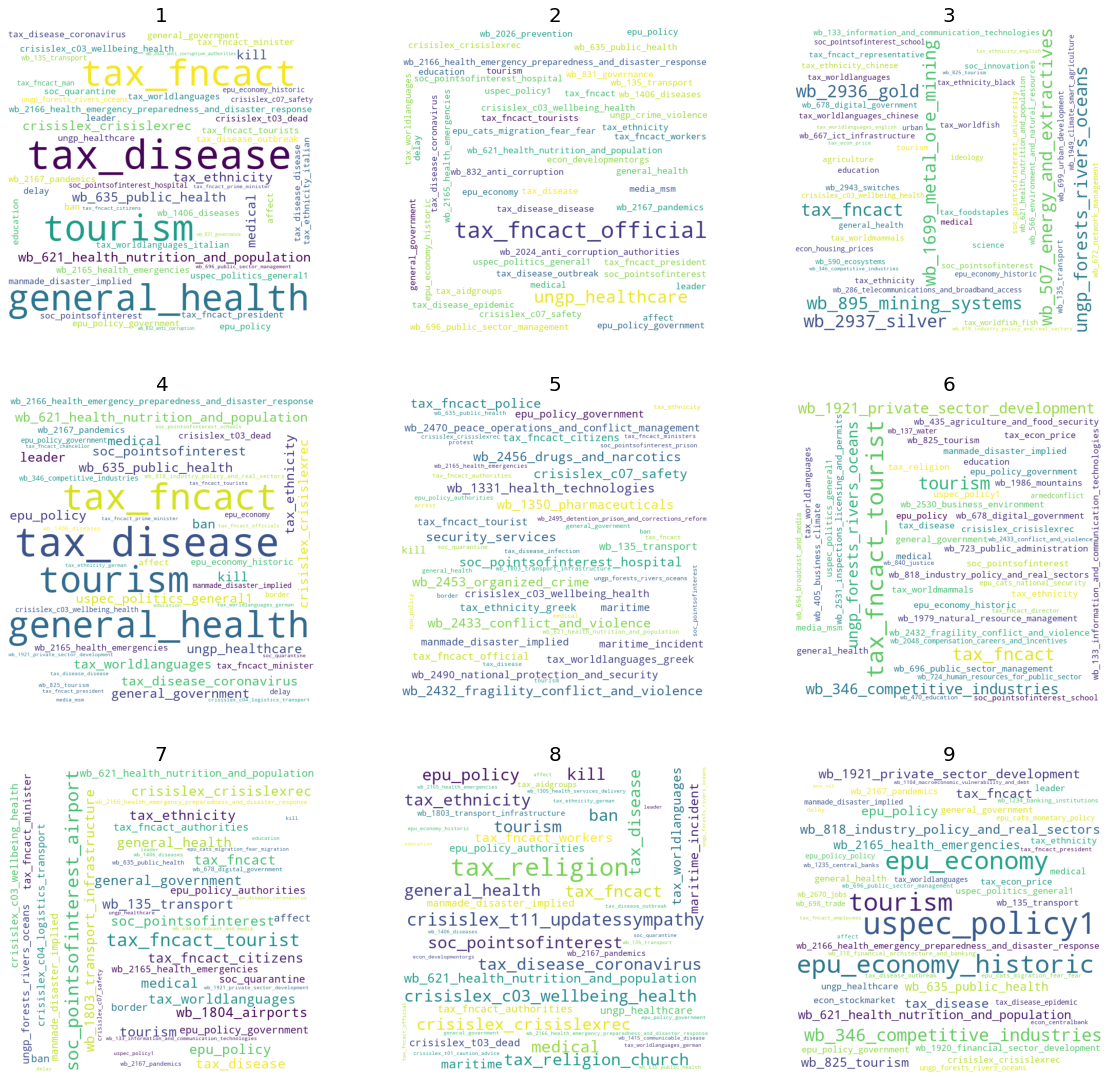

In [15]:
from google.cloud import bigquery
import pandas as pd
import datetime
import pickle
import numpy as np
import mlflow
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import LatentDirichletAllocation as LDA


client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))



# to be used on the following datasets
# datasets = [
#     "f5_prospects_af_mn theme_group",
#     "f5_prospects_in_ol theme_group",
#     "f5_prospects_us_tk theme_group",
#     "f5_prospects_sw_tm theme_group",
#     "f5_prospects_ua_en theme_group"
# ]

data_set_name = "f5_prospects_sw_tm "


# Define the query
query = """
SELECT * FROM `credit-suisse20-rem-2026.F5.f5_prospects_sw_tm` LIMIT 10000
  """

# Execute the query & save results to a dataframe
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

prospects_df = query_job.to_dataframe()

# Function to remove non_ascii
def remove_non_ascii(text):
  printable = set(string.printable)
  return ''.join(filter(lambda x: x in printable, text))

# Fun to exclude headers
def not_header(line):
  # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
  return not line.isupper()

# Get the list of tags & persons
tags_text = prospects_df['Tags'].to_list()
persons_text = prospects_df['Persons'].to_list()

# Replace punctuations with spaces
tags_corpus = [e.replace(";", " ") for e in tags_text]
persons_corpus = [e.replace(" ", "_").replace(";", " ") for e in persons_text]

tags_corp_string = ""
for item in tags_corpus:
    tags_corp_string = tags_corp_string + item

persons_corp_string = ""
for item in persons_corpus:
    persons_corp_string = persons_corp_string + item

word_cloud = WordCloud(
    background_color="white",
    max_words=500,
    width=900,
    height=700,
    contour_width=3,
    contour_color='steelblue'
)

plt.figure(figsize=(10,10))
word_cloud.generate(tags_corp_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(data_set_name + "word-cloud-tags-" + str(datetime.datetime.now()) + ".png")
plt.show()

plt.figure(figsize=(10,10))
word_cloud.generate(persons_corp_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(data_set_name + "word-cloud-persons-" + str(datetime.datetime.now()) + ".png")
plt.show()

vectorizer = TfidfVectorizer(max_features=300)
vectorizer = vectorizer.fit(tags_corpus[:1000])
df_train = vectorizer.transform(tags_corpus[:1000])
pickle.dump(vectorizer, open(data_set_name + "vectorizer-" + str(datetime.datetime.now()) + ".pkl" , 'wb'))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tags_corpus[:1000])
pickle.dump(tokenizer, open(data_set_name + "tokenizer-" + str(datetime.datetime.now()) + ".pkl" , 'wb'))
maxlen = 50
sequences_train = tokenizer.texts_to_sequences(tags_corpus[:1000])
sequences_train = pad_sequences(sequences_train, maxlen=maxlen)

feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(df_train.toarray()).flatten()[::-1]
n = 10
top_n = feature_array[tfidf_sorting][:n]
print(top_n)


# We ensure relevance of our topics using simple wordcloud visualisation
def word_cloud_builder(model, tf_feature_names, index):
    
    imp_words_topic=""
    comp = model.components_[index]
    vocab_comp = zip(tf_feature_names, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    
    return WordCloud(
        background_color="white",
        width=600, 
        height=600, 
        contour_width=3, 
        contour_color='steelblue'
    ).generate(imp_words_topic)


d = vectorizer.vocabulary_
word_cloud = WordCloud(
    background_color="white",
    max_words=500, 
    width=900, 
    height=700, 
    contour_width=3, 
    contour_color='steelblue'
)
plt.figure(figsize=(10,10))
word_cloud.generate_from_frequencies(frequencies=d)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(data_set_name + "word-cloud-persons-tfidf-" + str(datetime.datetime.now()) + ".png")
plt.show()


# Compare to NMF, LDA would not require inverse document frequency as it will learn probability distribution of term frequencies
word_tf_vectorizer = CountVectorizer(ngram_range=(1,1))
word_tf = word_tf_vectorizer.fit_transform(tags_corpus)
pickle.dump(word_tf_vectorizer, open(data_set_name + "word_tf_vectorizer-" + str(datetime.datetime.now()) + ".pkl" , 'wb'))


# # serialize stopwords
# json_data = json.dumps([a for a in stop_words], indent=2)
# f = open("/tmp/stopwords.json", "w")
# f.write(json_data)
# f.close()
lda = None
# track experiment on MLflow
with mlflow.start_run(run_name='topic_modelling'):
  
  # Train a LDA model with 9 topics
  lda = LDA(random_state = 42, n_components = 9, learning_decay = .3)
  lda.fit(word_tf)
  
  # Log model 
  mlflow.sklearn.log_model(lda, "model")
  mlflow.log_param('n_components', '9')
  mlflow.log_param('learning_decay', '.3')
  mlflow.log_metric('perplexity', lda.perplexity(word_tf))
#   mlflow.log_artifact("/tmp/stopwords.json")
  
  # retrieve run ID to attach topic name later
  lda_run_id = mlflow.active_run().info.run_id
    
pickle.dump(lda, open(data_set_name + "lda-" + str(datetime.datetime.now()) + ".pkl" , 'wb'))
    
# Retrieve top N words describing each of our 9 topics
def top_words(model, feature_names, n_top_words):
  rows = []
  for topic_idx, topic in enumerate(model.components_):
    message = ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    rows.append(["Topic #%d: " % (topic_idx + 1), message])
  return pd.DataFrame(rows, columns=['topic', 'keywords'])

# Display topics keywords for inspection and for us to label topics
tf_feature_names = word_tf_vectorizer.get_feature_names()
tw = top_words(lda, tf_feature_names, 15)
display(tw)
pickle.dump(tw, open(data_set_name + "tw-" + str(datetime.datetime.now()) + ".pkl" , 'wb'))


# We estimated our topics to be described around the following themes
topic_names = [
  '1',
  '2', 
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'
]

# serialize topic names
json_data = json.dumps(topic_names, indent=2)
f = open("./topics.json", "w")
f.write(json_data)
f.close()

# attach topics name to LDA model on mlflow
# we do not wish to re-open run_id and therefore alter start / end time
# instead, we log artifact to existing run
client = mlflow.tracking.MlflowClient()
client.log_artifact(lda_run_id, "./topics.json")

topics = len(lda.components_)
fig = plt.figure(figsize=(20, 20 * topics / 3))

# Display wordcloud for each extracted topic
for i, topic in enumerate(lda.components_):
    ax = fig.add_subplot(topics, 3, i + 1)
    ax.set_title(topic_names[i], fontsize=20)
    wordcloud = word_cloud_builder(lda, tf_feature_names, i)
    ax.imshow(wordcloud)
    ax.axis('off')
    
fig.savefig(data_set_name + "word-cloud-themes-" + str(datetime.datetime.now()) + ".png")

In [16]:
transformed = lda.transform(word_tf)

# find principal topic from distribution...
a = [topic_names[np.argmax(distribution)] for distribution in transformed]

# ... with associated probability
b = [np.max(distribution) for distribution in transformed]

# consolidate LDA output into a handy dataframe 
#df1 = esg[['company', 'lemma', 'statement']]
df1 = prospects_df
df2 = pd.DataFrame(zip(a,b,transformed), columns=['topic', 'probability', 'probabilities'])
theme_group = pd.concat([df1, df2], axis=1)

# display dataframe
display(theme_group.head())

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Source            SourceID  \
0  GDELT  20200301141500-219   
1  GDELT   20200301141500-18   
2  GDELT   20200301141500-28   
3  GDELT  20200301141500-159   
4  GDELT  20200301141500-571   

                                             Persons  \
0  khazanah nasional bhd;nikol pashinyan;katsunob...   
1  hamad al-thani;fei liu;donald trump;robert red...   
2  hamad al-thani;fei liu;donald trump;robert red...   
3  hamad al-thani;fei liu;donald trump;robert red...   
4  hamad al-thani;fei liu;donald trump;robert red...   

                                           Locations  \
0  3#King County, Washington, United States#US#US...   
1  1#Qatar#QA#QA#25.5#51.25#QA;1#Australia#AS#AS#...   
2  1#Qatar#QA#QA#25.5#51.25#QA;1#Australia#AS#AS#...   
3  1#Qatar#QA#QA#25.5#51.25#QA;1#Australia#AS#AS#...   
4  1#Qatar#QA#QA#25.5#51.25#QA;1#Australia#AS#AS#...   

                                  DocumentIdentifier  \
0  https://www.msn.com/en-us/news/world/iran-case...   
1  https://www.israelherald.com/news/264180355/ne...   
2  https://www.malaysiasun.com/news/264180355/new...   
3  https://www.pakistantelegraph.com/news/2641803...   
4  https://www.londonmercury.com/news/264180355/n...   

                                            Mentions  \
0  KILL#11##1#Iran#IR#IR#32#53#IR;KILL#35#new#1#S...   
1  KILL#70##1#Japan#JA#JA#36#138#JA;CRISISLEX_T03...   
2  KILL#70##1#Japan#JA#JA#36#138#JA;CRISISLEX_T03...   
3  KILL#70##1#Japan#JA#JA#36#138#JA;CRISISLEX_T03...   
4  KILL#70##1#Japan#JA#JA#36#138#JA;CRISISLEX_T03...   

                                                Tags    GKG_DATE topic  \
0  TAX_FNCACT;TAX_FNCACT_MAN;SCIENCE;TAX_FNCACT_R...  2020-03-01     1   
1  KILL;TAX_DISEASE;TAX_DISEASE_CORONAVIRUS;TAX_D...  2020-03-01     1   
2  KILL;TAX_DISEASE;TAX_DISEASE_CORONAVIRUS;TAX_D...  2020-03-01     1   
3  KILL;TAX_DISEASE;TAX_DISEASE_CORONAVIRUS;TAX_D...  2020-03-01     1   
4  KILL;TAX_DISEASE;TAX_DISEASE_CORONAVIRUS;TAX_D...  2020-03-01     1   

   probability                                      probabilities  
0     0.516171  [0.5161713085397883, 0.0008057348089192583, 0....  
1     0.991365  [0.9913646765357299, 0.0010793600463270174, 0....  
2     0.991365  [0.9913646765357299, 0.0010793600463270174, 0....  
3     0.991365  [0.9913646765357299, 0.0010793600463270174, 0....  
4     0.991365  [0.9913646765357299, 0.0010793600463270174, 0....

In [17]:
theme_group.to_csv("theme_group.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df = theme_group

In [19]:
df["topic"].value_counts()

9    1755
1    1752
4    1743
7    1533
6    1194
2     921
8     835
5     209
3      58
Name: topic, dtype: int64

1752


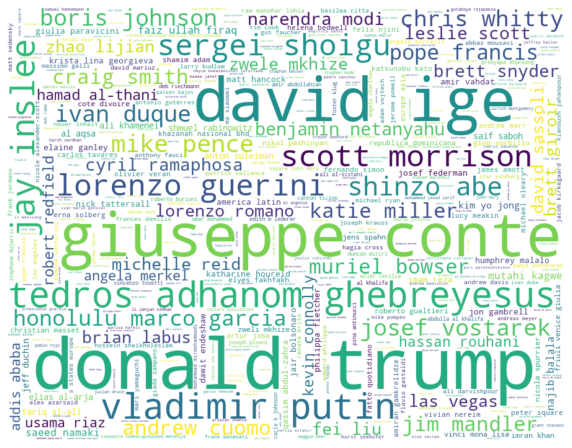

921


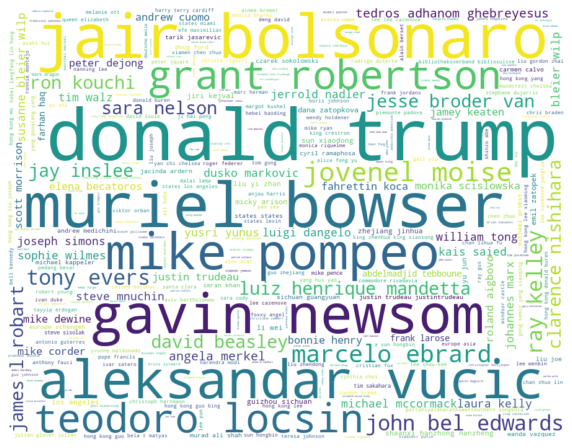

58


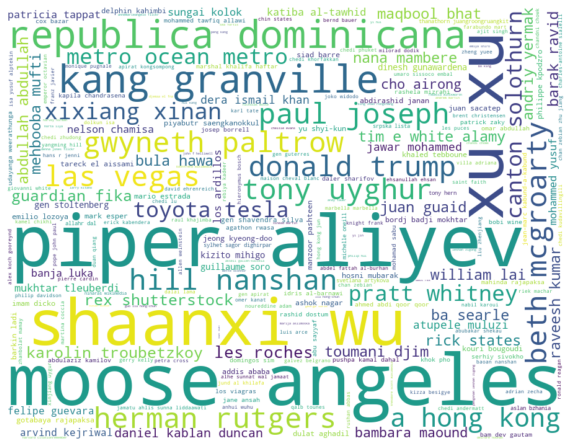

1743


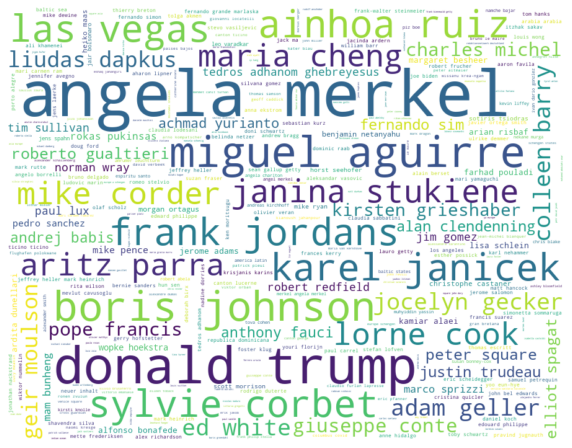

209


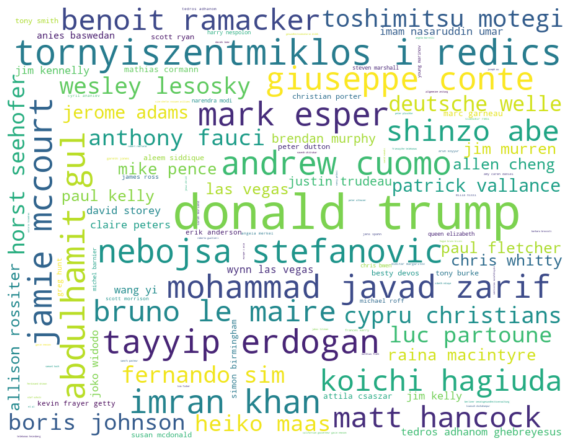

1194


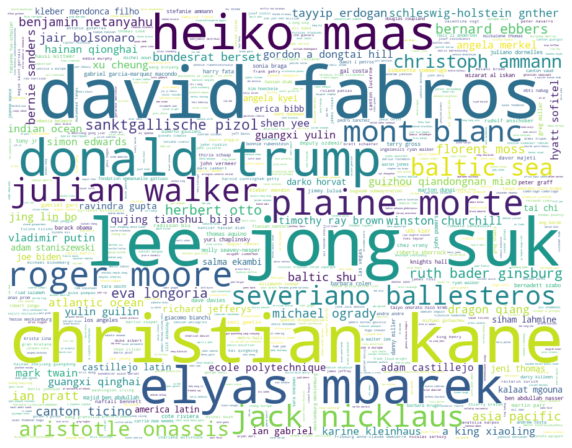

1533


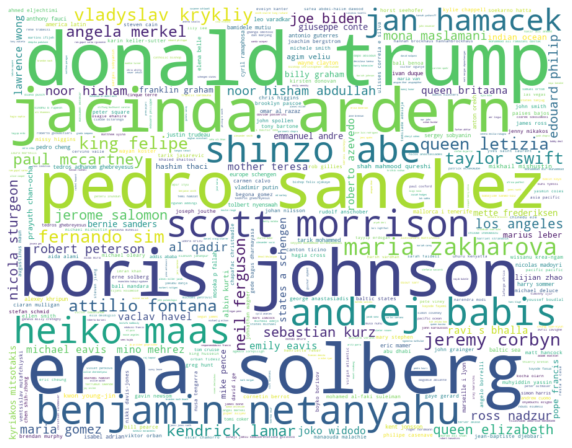

835


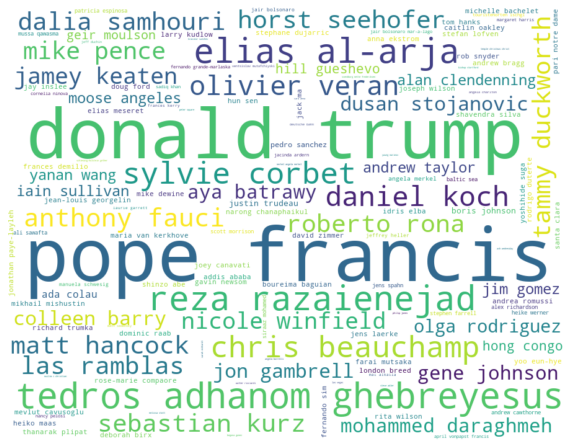

1755


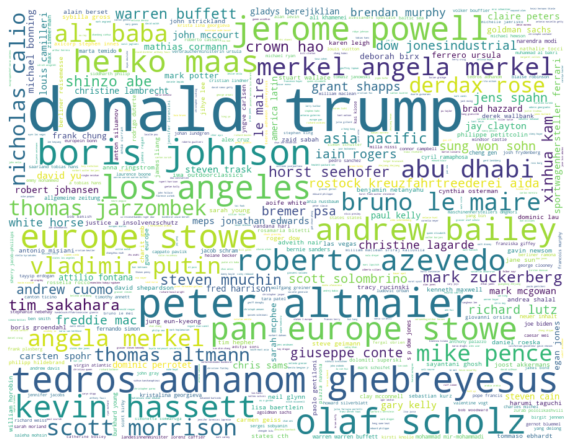

In [20]:
for topic_value in range(1, 10):
    people = dict()

    p_df = df.loc[df['topic'] == str(topic_value)]
    
    persons = p_df["Persons"].to_list()
    probabilities = p_df["probability"].to_list()
    pre_processed = p_df["probabilities"].to_list()
    topics = p_df["topic"].to_list()
    probabilities_vector = []

    for probabilities_vec in pre_processed:
#         probabilities_vec = probabilities_vec[1:-1]
#         probabilities_vec = probabilities_vec.split(" ")
        probabilities_vec = [float(e) for e in probabilities_vec]
        probabilities_vector.append(probabilities_vec)

    print(len(probabilities_vector))
    
    for i in range(len(persons)):
        for p in persons[i].split(";"):
            if p not in people:
                people[p] = dict()
                people[p]['count'] = 1
                people[p]['prob'] = probabilities[i]
                people[p]['prob_vec'] = probabilities_vector[i]
                people[p]['topics'] = [topics[i]]
            else:
                people[p]['count'] += 1
                people[p]['prob'] += probabilities[i]
                for idx in range(len(people[p]['prob_vec'])):
                    people[p]['prob_vec'][idx] += probabilities_vector[i][idx]
                people[p]['topics'].append(topics[i])

    for k, v in people.items():
        people[k]['agg_prob'] = v['prob'] / v['count']
        people[k]['agg_prob_vec'] = []
        for p_vec in people[k]['prob_vec']:
            people[k]['agg_prob_vec'].append(p_vec/v['count'])

    people_list = dict()
    for k, v in people.items():
        people_list[k] = v['count']

    word_cloud = WordCloud(
        background_color="white",
        max_words=5000, 
        width=900, 
        height=700, 
        contour_width=3, 
        contour_color='steelblue'
    )

    plt.figure(figsize=(10,10))
    word_cloud.generate_from_frequencies(frequencies=people_list)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("./plots/" + data_set_name + "__topic_" + str(topic_value) + "people_cloud.png")

    plt.show()